In [ ]:
!pip install spacy-sentence-bert
!pip install scikit-learn
!python -m spacy download en_core_web_md
!pip install -U sentence-transformers
!pip install nlpaug

In [3]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

datasets_donwload_urllink = "https://drive.google.com/file/d/10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N/view?usp=drive_link"
file_id = '10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N'
user_interactions_url = f'https://drive.google.com/uc?id={file_id}'
topics_url = 'https://docs.google.com/spreadsheets/d/1FK1MxaY0U0KNxwXrAxbEfm4ylxWpY3o-QGiD5LpVK38/export?format=csv'

In [4]:
nlp = spacy.load("en_core_web_md")

Helper Functions

In [5]:
def anonymize_names_v2(doc):
    text = doc.text
    replacements = {}
    name_id = 1

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            replacements[(ent.start_char, ent.end_char)] = f"[NAME_{name_id}]"
            name_id += 1

    # Sort from last to first to avoid offset shifting
    new_text = text
    for (start, end), placeholder in sorted(replacements.items(), reverse=True):
        new_text = new_text[:start] + placeholder + new_text[end:]

    return new_text, replacements

def deanonymize_text(text, mapping):
    reverse_mapping = {v: k for k, v in mapping.items()}
    for anon, original in reverse_mapping.items():
        text = text.replace(anon, original)
    return text
    # revert back code
    # Add a column with the reverted text
    # df['deanonymized'] = df.apply(lambda row: deanonymize_text(row['anonymized'], row['name_mapping']), axis=1)

def text_topic_similarity(text, topic):
    doc1 = nlp(text)
    doc2 = nlp(topic)

    return doc1.similarity(doc2)

In [6]:
df = pd.read_csv(user_interactions_url)
df_topics = pd.read_csv(topics_url)

df.columns = ["rowid", "interaction", "label"]
df["anonymized_interaction"] = ''

### Perform Anonymization

In [7]:
anonymized_results = []
replacement_maps = []

for doc in nlp.pipe(df['interaction'], batch_size=50):
    anonymized_text, mapping = anonymize_names_v2(doc)
    anonymized_results.append(anonymized_text)
    replacement_maps.append(mapping)

# Store results
df['anonymized_interaction'] = anonymized_results
df['name_mapping'] = replacement_maps

In [8]:
df_anonymized = df[["rowid", "anonymized_interaction", "label"]]

### Perform Label evaluation and replacement

#### Before adding new label, evaluate original distribution and average confidence score with

In [9]:
df_anonymized = df_anonymized.replace({'label':
    {
        "AccountDetails":"Account Details",
        "Loan":"Loan and Credit Services","HomeLoan":"Loan and Credit Services","AutoLoan":"Loan and Credit Services",
        "DebitCard":"Debit/Credit Card","CreditCard":"Debit/Credit Card",
        "Offers":"Product Inquiries",
        "Grievances":"Complaints",
        "TechSupport":"Technical Support"
    }
})
df_anonymized["original_label_confidence"] = 0

In [10]:
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import torch
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
# 1- Precompute text embeddings: text input
text_inputs = df_anonymized["anonymized_interaction"].tolist()
text_embeddings = model.encode(text_inputs, convert_to_tensor=True)

In [12]:
# 2- compute original label confidence with sentence transformer and cosine sim
old_labels = df_anonymized["label"].tolist()
old_label_embeddings = model.encode(old_labels, convert_to_tensor=True)
old_labels_confidence_score = []

for i in range(len(text_embeddings)):
    sim = util.cos_sim(text_embeddings[i], old_label_embeddings[i])
    old_labels_confidence_score.append(sim.item())  # Convert 1x1 tensor to float

df_anonymized['original_label_confidence'] = old_labels_confidence_score

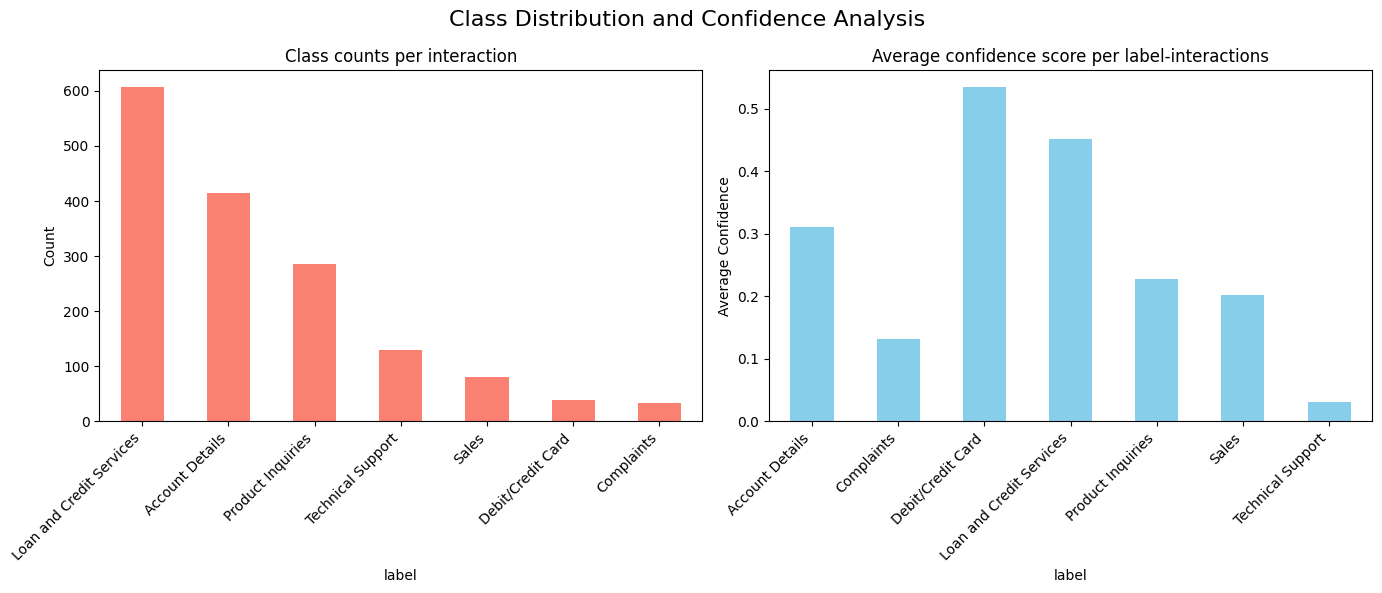

In [13]:
# Label analysis on original datasets(anonymized) class distribution and average confidence per class
class_counts = df_anonymized['label'].value_counts()
old_avg = df_anonymized.groupby('label')['original_label_confidence'].mean()

# Create side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Class Distribution and Confidence Analysis", fontsize=16)

# Plot class counts (left)
class_counts.plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title("Class counts per interaction")
ax1.set_ylabel("Count")
ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')

# Plot average confidence (right)
old_avg.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title("Average confidence score per label-interactions")
ax2.set_ylabel("Average Confidence")
ax2.set_xticklabels(old_avg.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Add new label with their confidence score

#### Zero shot classification with new topics

In [14]:
df_anonymized["new_label"] = ""
df_anonymized["new_label_confidence"] = 0

In [15]:
# 2- Precompute topics embeddings: new topics and text input
# topics_embeddings = model.encode(topics, convert_to_tensor=True) --- Old method
topic_embeddings = {}
for topic, group in df_topics.groupby("topic"):
    enriched_texts = (
        "Topic: " + group["topic"] +
        ". Description: " + group["description"] +
        " Example: " + group["example"]
    ).tolist()

    embeddings = model.encode(enriched_texts, convert_to_tensor=True)
    avg_embedding = torch.mean(embeddings, dim=0)
    topic_embeddings[topic] = avg_embedding


In [16]:
# 4- compute new label confidence with sentence transformer and cosine sim using enricheds topics

# Step 1: Extract topic names and their averaged embeddings
topic_names = list(topic_embeddings.keys())  # e.g., ['Account Details', 'Product Inquiries', ...]
topic_avg_embeddings = torch.stack([topic_embeddings[topic] for topic in topic_names])  # shape: [num_topics, emb_dim]

# Step 2: Prepare to store results
predicted_topics = []
topics_confidence_scores = []

for text_emb in tqdm(text_embeddings):
    similarities = util.cos_sim(text_emb, topic_avg_embeddings)  # shape: [1, num_topics]
    best_idx = similarities.argmax().item()
    predicted_topics.append(topic_names[best_idx])
    topics_confidence_scores.append(similarities[0][best_idx].item())

# Step 3: save new labels and confidence score
df_anonymized["new_label"] = predicted_topics
df_anonymized["new_label_confidence"] = topics_confidence_scores

100%|██████████| 1588/1588 [00:00<00:00, 10092.77it/s]


In [17]:
df_anonymized[["label", "original_label_confidence", "new_label", "new_label_confidence"]].head(2)

,label,original_label_confidence,new_label,new_label_confidence
0,Loan and Credit Services,0.504656,Loan and Credit Services,0.418912
1,Loan and Credit Services,0.432348,Loan and Credit Services,0.360671


### Label distribution and comparison

In [18]:
#df_anonymized['new_label'].value_counts()
#df_anonymized['label'].value_counts()

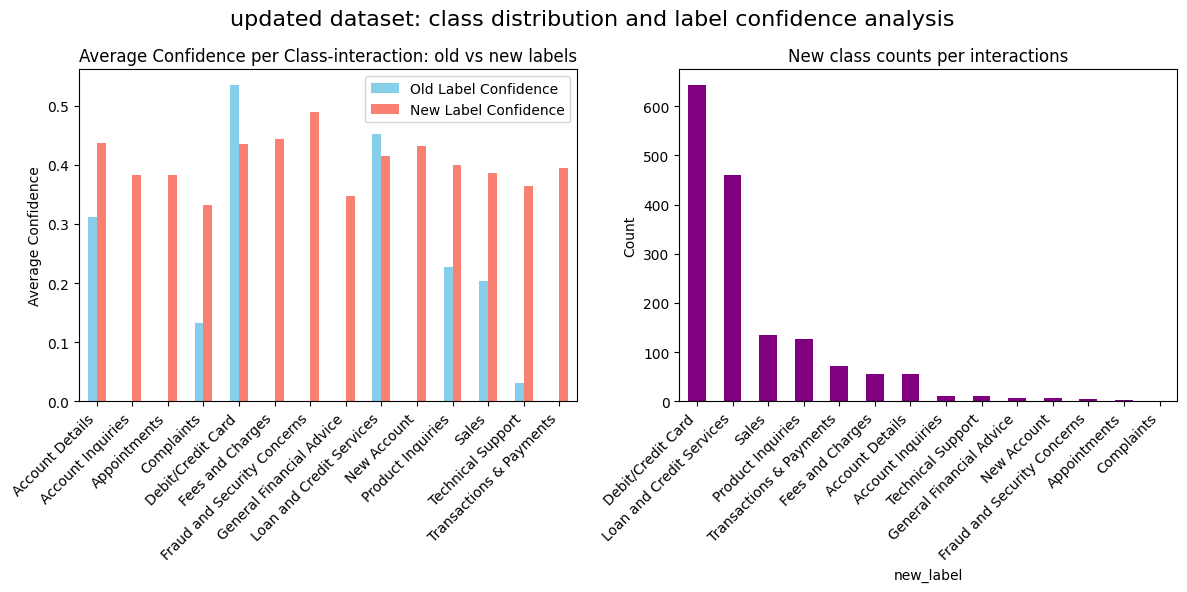

In [19]:
new_class_counts = df_anonymized['new_label'].value_counts()
old_avg = df_anonymized.groupby('label')['original_label_confidence'].mean()
new_avg = df_anonymized.groupby('new_label')['new_label_confidence'].mean()

comparison_df = pd.DataFrame({
    'Old Label Confidence': old_avg,
    'New Label Confidence': new_avg
}).fillna(0)

# Create side-by-side bar charts
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig1.suptitle("updated dataset: class distribution and label confidence analysis", fontsize=16)

# Plot class counts (left)
new_class_counts.plot(kind='bar', ax=ax2, color='purple')
ax2.set_title("New class counts per interactions")
ax2.set_ylabel("Count")
ax2.set_xticklabels(new_class_counts.index, rotation=45, ha='right')

# Plot grouped bar chart (right)
import matplotlib.pyplot as plt
comparison_df.plot(kind='bar', ax=ax1, figsize=(12, 6), color=['skyblue', 'salmon'])
ax1.set_ylabel("Average Confidence")
ax1.set_title("Average Confidence per Class-interaction: old vs new labels")
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Deal with label imbalance: apply oversampling with data augmentation

In [20]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For multilingual WordNet synonyms (optional but recommended)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [21]:
majority_classes = ["Debit/Credit Card Issues","Loan and Credit Services",]
minority_classes = [topic for topic in df_anonymized['new_label'].unique() if topic not in majority_classes]

In [22]:
df_anonymized = df_anonymized[["anonymized_interaction","new_label"]]
df_anonymized_minority = df_anonymized[df_anonymized['new_label'].isin(minority_classes)]
df_anonymized_majority = df_anonymized[~df_anonymized['new_label'].isin(minority_classes)]

In [23]:
df_anonymized_majority.head(3)

,anonymized_interaction,new_label
0,"Hi [NAME_1], my name is [NAME_2]. What are the...",Loan and Credit Services
1,"Hi [NAME_1], my name is [NAME_2], How long doe...",Loan and Credit Services
2,"Hi [NAME_1], my name is [NAME_2], What docume...",Loan and Credit Services


In [24]:
aug = naw.SynonymAug(aug_src='wordnet', model_path='en_core_web_md')

target = 450  # target_count_per_augmentation_perclass (mean or median of max class)
minority_counts = df_anonymized_minority['new_label'].value_counts()

repeats_per_class = {
    label: max((target - count) // count, 0)
    for label, count in minority_counts.items()
}

In [ ]:
# del(df_augmented)
# del(df_balanced)
# del(augmented_texts)

In [46]:
augmented_texts = []
for label, group in df_anonymized_minority.groupby('new_label'):
    n_repeat = repeats_per_class[label]
    for _, row in group.iterrows():
        for _ in range(n_repeat):
            augmented_texts.append({
                "anonymized_interaction": aug.augment(row['anonymized_interaction']),
                "new_label": label
            })

In [48]:
# df_augmented = pd.DataFrame(augmented_texts)
# df_balanced = pd.concat([df_anonymized_majority, df_anonymized_minority, df_augmented], ignore_index=True)
#augmented_texts = [' '.join(tokens) for tokens in augmented_texts]
#df_augmented = pd.DataFrame({'anonymized_interaction': augmented_texts})

cleaned_augmented_texts = [
    {
        'anonymized_interaction': item['anonymized_interaction'][0] if isinstance(item['anonymized_interaction'], list) else item['anonymized_interaction'],
        'new_label': item['new_label']
    }
    for item in augmented_texts
]
df_augmented = pd.DataFrame(cleaned_augmented_texts)
df_balanced = pd.concat([df_anonymized_majority, df_anonymized_minority, df_augmented], ignore_index=True)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [49]:
# assert df_balanced['anonymized_interaction'].apply(lambda x: isinstance(x, str)).all()
# df_balanced.head(2)

,anonymized_interaction,new_label
0,"Howdy [NAME_1 ], my gens is [NAME_2 ]. Can I c...",Appointments
1,"Hi [NAME_1 ], my name is [NAME_2 ], Hi, poster...",New Account


In [47]:
#df_balanced.sample(10)
augmented_texts

[{'anonymized_interaction': ["Hi [NAME_1 ], my epithet represent [NAME_2 ], Howdy, One ' m take care for a credit menu with a mobile app for easy account management. Perform you have any options like that? I ' m interested in obtaining some data. Could you wait on pine tree state?"],
  'new_label': 'Account Details'},
 {'anonymized_interaction': ["Aloha state [NAME_1 ], my name be [NAME_2 ], Aloha state, I ' m looking for a credit card with a nomadic app for easy account direction. Do you own any options like that? I ' m interested in obtaining some data. Could you assist maine?"],
  'new_label': 'Account Details'},
 {'anonymized_interaction': ["Hi [NAME_1 ], my name represent [NAME_2 ], Hi, I ' grand looking for a credit circuit board with a mobile app for easy write up management. Do you have any selection like that? I ' m interested in get some data. Could you assist me?"],
  'new_label': 'Account Details'},
 {'anonymized_interaction': ["Hi [NAME_1 ], my name is [NAME_2 ], How do yo

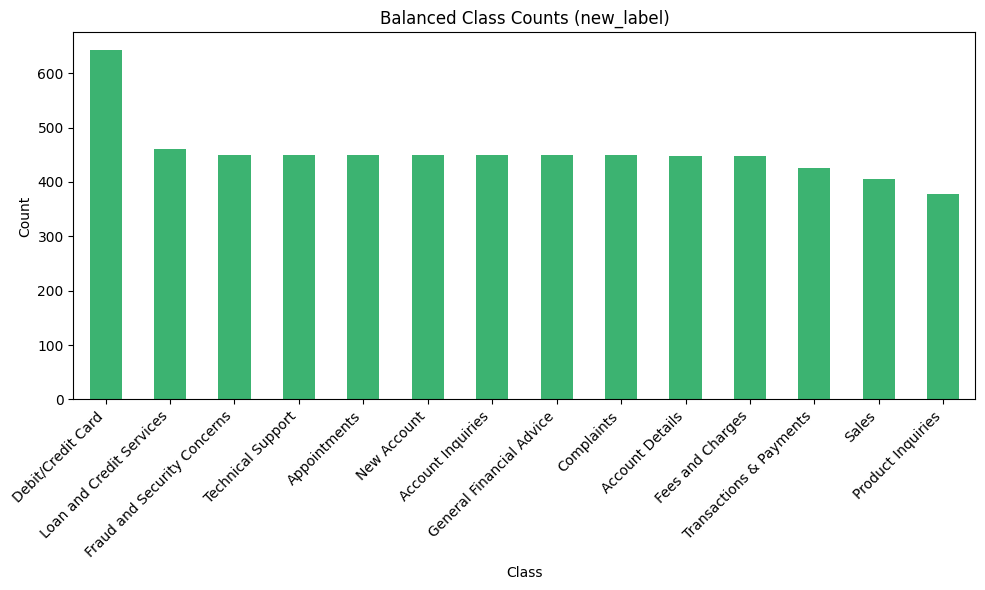

In [50]:
balanced_class_counts = df_balanced['new_label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
balanced_class_counts.plot(kind='bar', color='mediumseagreen')
plt.title("Balanced Class Counts (new_label)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Model Evaluation

In [56]:
import spacy_sentence_bert
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
# Load model and vectorize
nlpwrapper = spacy_sentence_bert.load_model('en_stsb_distilbert_base')
df_balanced['vector'] = df_balanced['anonymized_interaction'].apply(lambda x: nlpwrapper(x).vector)

In [54]:
# Split data
X = df_balanced['vector'].tolist()
y = df_balanced['new_label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
# Define models
models = {
    "SVC (RBF Kernel)": SVC(),
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification report for {name}:\n")
    print(classification_report(y_test, y_pred))


Training model: SVC (RBF Kernel)
Classification report for SVC (RBF Kernel):

                             precision    recall  f1-score   support

            Account Details       0.79      0.81      0.80       143
          Account Inquiries       0.85      0.90      0.87       142
               Appointments       0.91      0.99      0.95       145
                 Complaints       1.00      1.00      1.00       159
          Debit/Credit Card       0.81      0.89      0.85       187
           Fees and Charges       0.87      0.81      0.84       155
Fraud and Security Concerns       0.97      0.94      0.96       151
   General Financial Advice       0.98      1.00      0.99       157
   Loan and Credit Services       0.83      0.90      0.86       137
                New Account       0.99      0.99      0.99       139
          Product Inquiries       0.90      0.80      0.85       143
                      Sales       0.80      0.80      0.80       127
          Technical Sup

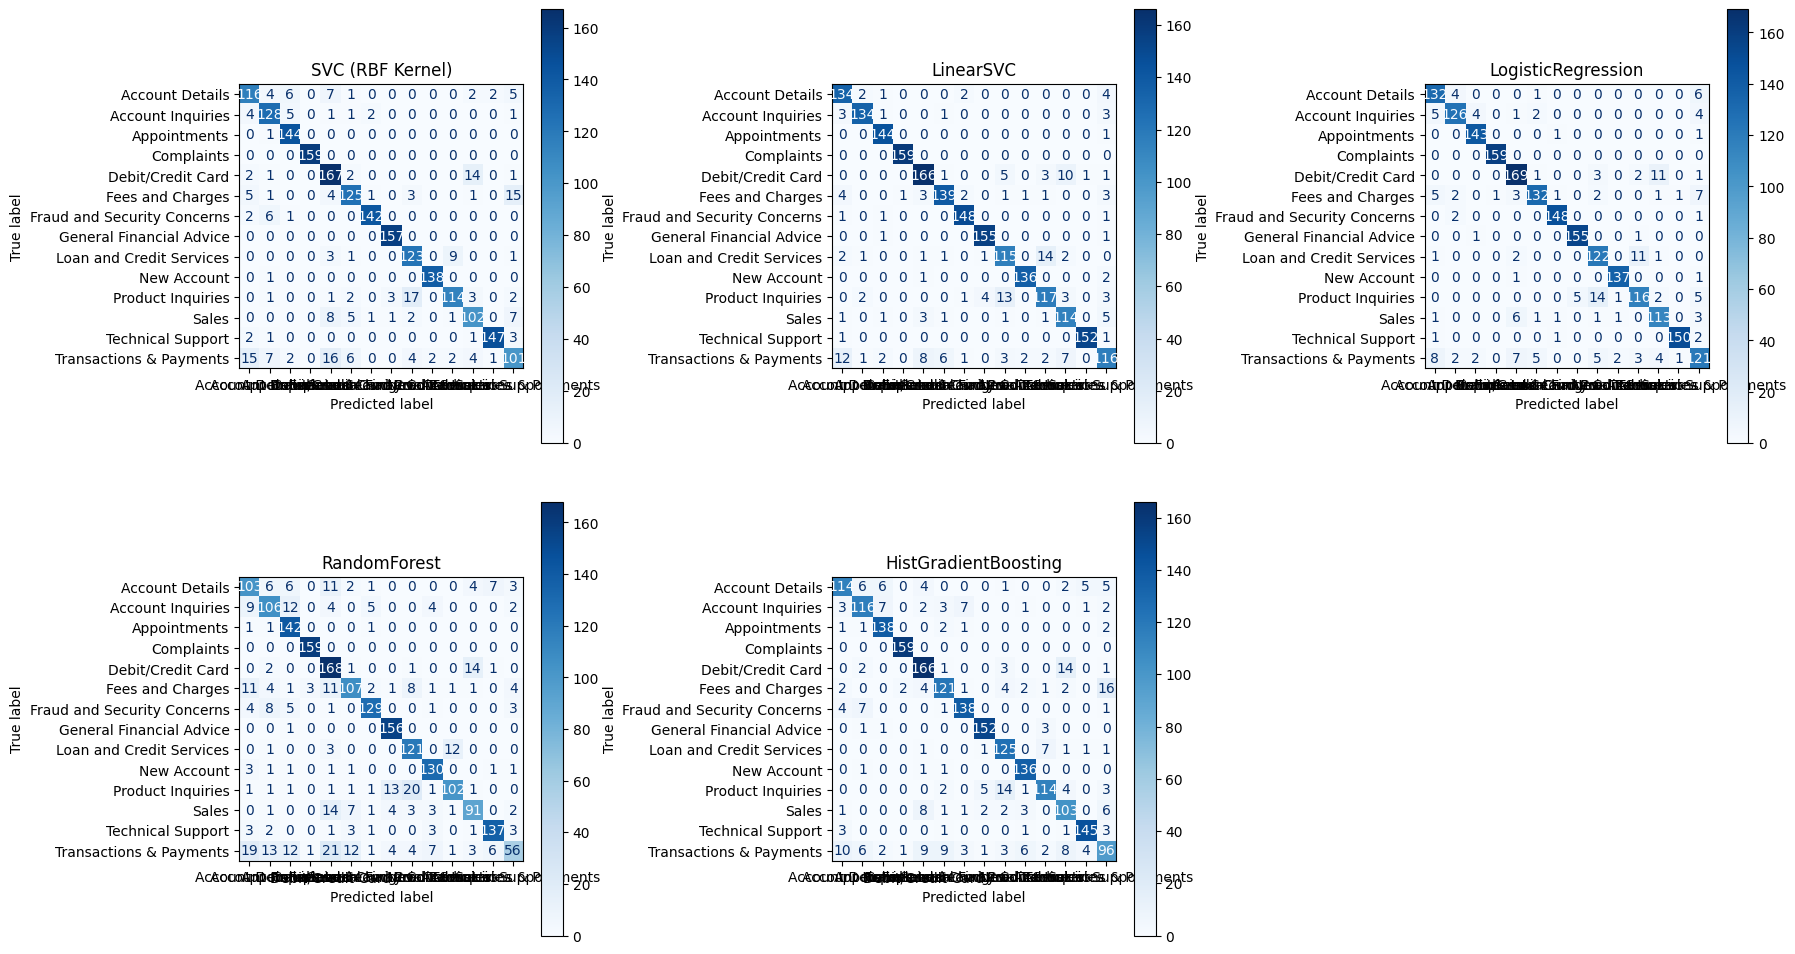

In [59]:
# Fit models and store confusion matrices
fig3, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust based on number of models
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_ if hasattr(model, 'classes_') else sorted(set(y_train)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, 'classes_') else sorted(set(y_train)))
    disp.plot(ax=axes[idx], values_format='d', cmap='Blues')
    axes[idx].set_title(name)

# Hide any unused subplot axes
for i in range(len(models), len(axes)):
    fig3.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Store model accuracies
accuracy_data = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_data.append({'Model': name, 'Accuracy': acc})

# Create DataFrame for display
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(accuracy_df)


                  Model  Accuracy
0             LinearSVC  0.919009
1    LogisticRegression  0.916151
2      SVC (RBF Kernel)  0.887566
3  HistGradientBoosting  0.868509
4          RandomForest  0.814674


In [61]:
import joblib

In [62]:
# Access the trained model
linearsvc_model = models["LinearSVC"]

# Export to file
joblib.dump(linearsvc_model, "linear_svc_model.pkl")

['linear_svc_model.pkl']